# Importing necessary libraires

In [ ]:
import random
import time
import pandas as pd
import numpy as np
import re
import torch
import string

from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from tensorflow.python.keras.preprocessing import text, sequence
from tensorflow.python.keras.models import Sequential
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from tensorflow. keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report
from torch.optim.optimizer import Optimizer

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

### Parameters

In [ ]:
embed_size = 300 # how big is each word vector
max_features = 100000 # how many unique words to use (i.e num rows in embedding vector)
vocab_size = max_features
maxlen = 70 # max number of words in a question to use

#Dataset

In [ ]:
data_train = pd.read_csv("/content/training.1600000.processed.noemoticon.csv")
# data_train

In [ ]:
data_test = pd.read_csv("/content/testdata.manual.2009.06.14.csv")
# data_test.head()

## Finding the Length

In [ ]:
data_train['length'] = data_train['Utterance'].apply(lambda x: len(str(x).split()))
# data_train

In [ ]:
data_test['length'] = data_test['Utterance'].apply(lambda x: len(str(x).split()))
# data_test

In [ ]:
# def delete_row(df):
#   x = "Emotion"
#   df.drop(df.loc[df[x]=="neutral"].index, inplace=True)
#   return df 


# data_train = delete_row(data_train)
# data_test = delete_row(data_test)

##Text Preprocessing

In [ ]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am","im":"i am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
# Usage
replace_contractions("i didn't feel humiliated")

def text_preprocessing(text):
    text = replace_contractions(text)
    # text = remove_punct(text)
    # text = clean_text(text)
    text = text.lower()
    return text


In [ ]:
data_train["Utterance"] = data_train["Utterance"].apply(lambda x: text_preprocessing(x))
# data_train

In [ ]:
data_test["Utterance"] = data_test["Utterance"].apply(lambda x: text_preprocessing(x))
data_test

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,length
0,1,why do all youre coffee mugs have numbers on ...,Mark,surprise,positive,0,0,3,19,"00:14:38,127","00:14:40,378",11
1,2,oh. thats so monica can keep track. that way ...,Rachel,anger,negative,0,1,3,19,"00:14:40,629","00:14:47,385",22
2,3,y'know what?,Rachel,neutral,neutral,0,2,3,19,"00:14:56,353","00:14:57,520",2
3,19,"come on, lydia, you can do it.",Joey,neutral,neutral,1,0,1,23,"0:10:44,769","0:10:46,146",7
4,20,push!,Joey,joy,positive,1,1,1,23,"0:10:46,146","0:10:46,833",1
...,...,...,...,...,...,...,...,...,...,...,...,...
2605,2760,"yeah, i mean, come on ross, no one will even n...",Rachel,neutral,neutral,279,11,6,4,"00:14:35,457","00:14:40,211",18
2606,2761,they’re not listening too me?,Ross,surprise,negative,279,12,6,4,"00:14:42,256","00:14:43,840",5
2607,2762,of course they’re listening to you! everybody ...,Rachel,neutral,neutral,279,13,6,4,"00:14:44,008","00:14:48,511",10
2608,2763,monica you really think i should try this phas...,Ross,neutral,neutral,279,14,6,4,"00:14:48,138","00:14:52,390",11


In [ ]:
Labels = data_train['Emotion'].unique()

In [ ]:
def count_(df,x):
  ans = df.Emotion.value_counts()[x]
  return ans

# Labels = ['neutral', 'surprise', 'fear', 'sadness', 'joy', 'disgust','anger']
for x in Labels:
  cnt = count_(data_train,x)
  print(str(x) + " : " + str(cnt))

neutral : 4710
surprise : 1205
fear : 268
sadness : 683
joy : 1743
disgust : 271
anger : 1109


In [ ]:
X_train = data_train["Utterance"]
Y_train = data_train["Emotion"]

X_test = data_test["Utterance"]
Y_test = data_test["Emotion"]

print("Train shape : ",X_train.shape)
print("Test shape : ",X_test.shape)

Train shape :  (9989,)
Test shape :  (2610,)


## Padding Dataset
  Maximum Length = 70

In [ ]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
train_X = tokenizer.texts_to_sequences(X_train)
test_X = tokenizer.texts_to_sequences(X_test)

## Pad the sentences
train_X = pad_sequences(train_X, maxlen=maxlen, truncating='post', padding='post')
test_X = pad_sequences(test_X, maxlen=maxlen, truncating='post', padding='post')

In [ ]:
train_X

array([[417,   1,  33, ...,   0,   0,   0],
       [  2, 862, 100, ...,   0,   0,   0],
       [ 10,   1,  64, ...,   0,   0,   0],
       ...,
       [  2,  87,  27, ...,   0,   0,   0],
       [ 20,   0,   0, ...,   0,   0,   0],
       [ 10,  33,   5, ...,   0,   0,   0]], dtype=int32)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(Y_train.values)
test_y = le.transform(Y_test.values)
le.classes_

array(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness',
       'surprise'], dtype=object)

# Word Emebedding
We use the glove word embeddings

## Load Embeddings


In [ ]:
def load_glove(word_index):
    EMBEDDING_FILE = "/content/glove.6B.300d.txt"
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix
embedding_matrix = load_glove(tokenizer.word_index)
print('Shape of word embedding:',np.shape(embedding_matrix))

Shape of word embedding: (5934, 300)


In [ ]:
# model = Sequential()

# model.add(Embedding(max_features, embedding_dims, input_length=max_text_length))
# model.add(Dropout(0.2))

# model.add(Conv1D(filters=num_filters_1, kernel_size=filter_size, padding='valid', activation='relu', strides=1))
# model.add(GlobalMaxPooling1D())

# model.add(Dense(num_filters_2))
# model.add(Dropout(0.2))
# model.add(Activation('relu'))

# model.add(Dense(14))
# model.add(Activation('sigmoid'))

# Convolutional Neural Network (CNN)

In [ ]:
class CNN(nn.Module):
    
    def __init__(self,num_filters,filter_sizes,n_classes):
        super(CNN, self).__init__()

        #load pretrained embedding in embedding layer.
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.dropout = nn.Dropout(0.1)
        #Convolutional Layers with different window size kernels

        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        #convolutional layer
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        #Dropout layer
        self.dropout = nn.Dropout(0.1)

        #convolutional layer
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        #Dropout layer
        self.dropout = nn.Dropout(0.1)

        #convolutional layer
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        #Dropout layer
        self.dropout = nn.Dropout(0.1)
        
        #FC layer
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)

    def forward(self, x):
        x = self.embedding(x) 
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x)
        return logit

In [ ]:
n_epochs = 30
filter_sizes = [3,3]
num_filters = 132
n_classes = len(le.classes_)
batch_size = 50

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_cnn = CNN(num_filters,filter_sizes,n_classes).to(device)
loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_cnn.parameters()), lr=0.0001)

# Load train and test in CUDA or CPU Memory
x_train = torch.tensor(train_X, dtype=torch.long).to(device)
y_train = torch.tensor(train_y, dtype=torch.long).to(device)
x_cv = torch.tensor(test_X, dtype=torch.long).to(device)
y_cv = torch.tensor(test_y, dtype=torch.long).to(device)

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

cnn_train_loss = []
cnn_valid_loss = []
cnn_train_acc_list, cnn_test_acc_list, cnn_prec_list, cnn_recall_list, cnn_f1_list = [],[],[],[],[]

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model_cnn.train()
    avg_loss = 0.  
    train_preds = np.zeros((len(x_train),len(le.classes_)))
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model_cnn(x_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).detach().cpu().numpy()
        avg_loss += loss.item() / len(train_loader)

    
    y_pred_train = train_preds.argmax(axis=1)
    train_accuracy = round(accuracy_score(y_pred_train,train_y)*100,3)
    
    # Set model to validation configuration -Doesn't get trained here
    model_cnn.eval()      
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model_cnn(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Determining Accuracy, Precision, Recall, F1 Score
    y_pred = val_preds.argmax(axis=1)
    test_accuracy = round(accuracy_score(y_pred,test_y)*100,3)
    test_precision = round(precision_score(y_pred,test_y, average='weighted')*100,3)
    test_recall = round(np.mean(recall_score(y_pred, test_y, average='weighted'))*100,3)
    test_f1_score = round(f1_score(y_pred, test_y, average='weighted')*100,3)
  

    # storing accuracy,precision,recall,f1 score data into list
    cnn_train_loss.append(avg_loss)
    cnn_valid_loss.append(avg_val_loss)
    cnn_train_acc_list.append(train_accuracy)
    cnn_test_acc_list.append(test_accuracy)
    cnn_prec_list.append(test_precision)
    cnn_recall_list.append(test_recall)
    cnn_f1_list.append(test_f1_score)
    elapsed_time = time.time() - start_time
    print('Epoch {}/{}  Train loss={:.3f}   Test loss={:.3f}   Train Accuracy={:.3f}   Test Accuracy={:.3f}   Precision={:.3f}   Recall={:.3f}   F1 Score={:.3f}   time={:.2f} s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, train_accuracy, test_accuracy, test_precision, test_recall, test_f1_score, elapsed_time))

Epoch 1/30  Train loss=1.544   Test loss=1.476   Train Accuracy=46.291   Test Accuracy=48.352   Precision=99.775   Recall=48.352   F1 Score=64.938   time=1.72 s
Epoch 2/30  Train loss=1.476   Test loss=1.445   Train Accuracy=47.903   Test Accuracy=49.157   Precision=98.533   Recall=49.157   F1 Score=64.828   time=1.56 s
Epoch 3/30  Train loss=1.434   Test loss=1.421   Train Accuracy=48.924   Test Accuracy=49.962   Precision=96.577   Recall=49.962   F1 Score=64.407   time=1.57 s
Epoch 4/30  Train loss=1.401   Test loss=1.402   Train Accuracy=49.805   Test Accuracy=50.996   Precision=93.710   Recall=50.996   F1 Score=63.932   time=1.56 s
Epoch 5/30  Train loss=1.365   Test loss=1.385   Train Accuracy=51.066   Test Accuracy=52.184   Precision=89.884   Recall=52.184   F1 Score=63.462   time=1.56 s
Epoch 6/30  Train loss=1.337   Test loss=1.372   Train Accuracy=52.448   Test Accuracy=52.644   Precision=86.369   Recall=52.644   F1 Score=62.862   time=1.56 s
Epoch 7/30  Train loss=1.309   Tes

## Setting Hyperparameters

In [ ]:
print(model_cnn)

CNN(
  (embedding): Embedding(100000, 300)
  (dropout): Dropout(p=0.1, inplace=False)
  (convs1): ModuleList(
    (0): Conv2d(1, 132, kernel_size=(3, 300), stride=(1, 1))
    (1): Conv2d(1, 132, kernel_size=(3, 300), stride=(1, 1))
  )
  (fc1): Linear(in_features=264, out_features=7, bias=True)
)


##  Model Evaluation

In [ ]:
y_pred = val_preds.argmax(axis=1)
test_y = le.transform(Y_test.values)
print(classification_report(test_y,y_pred))

              precision    recall  f1-score   support

           0       0.37      0.17      0.23       345
           1       0.20      0.01      0.03        68
           2       0.38      0.06      0.10        50
           3       0.48      0.30      0.37       402
           4       0.58      0.84      0.68      1256
           5       0.34      0.17      0.23       208
           6       0.47      0.41      0.44       281

    accuracy                           0.53      2610
   macro avg       0.40      0.28      0.30      2610
weighted avg       0.49      0.53      0.49      2610



# Model Visualization

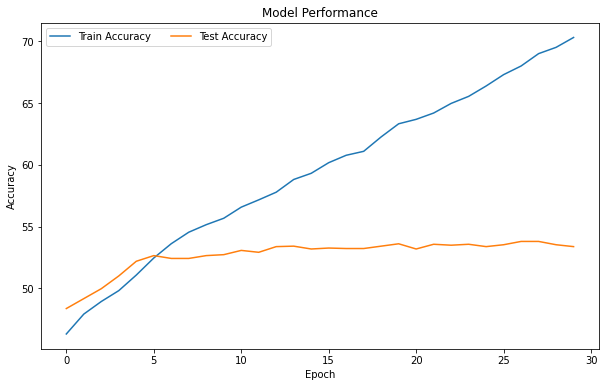

In [ ]:
plt.plot(cnn_train_acc_list, linestyle='-', label='Train Accuracy')
plt.plot(cnn_test_acc_list, linestyle='-', label='Test Accuracy')

plt.title('Model Performance')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='bottom right',ncol=2)
# plt.ylim(5.55,11.55)
plt.rcParams["figure.figsize"] = (10,6)
plt.savefig('/content/drive/MyDrive/MINI/Saved Files/final_cnn_model_performance_graph.jpg')
plt.show()

# Loss Curve of CNN

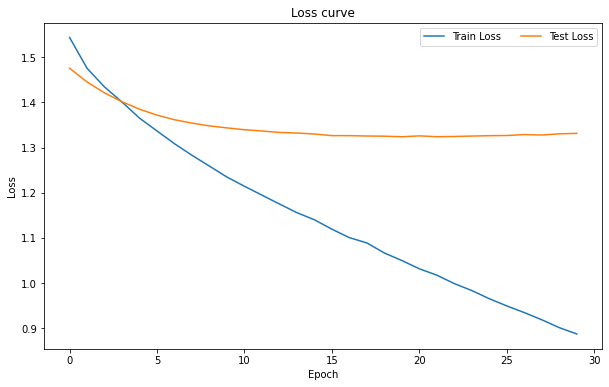

In [ ]:
plt.plot(cnn_train_loss, linestyle='-', label='Train Loss')
plt.plot(cnn_valid_loss, linestyle='-', label='Test Loss')

plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='bottom right',ncol=2)
plt.rcParams["figure.figsize"] = (10,6)
plt.savefig('/content/drive/MyDrive/MINI/Saved Files/Final_CNN_loss_curve.jpg')
plt.show()

# Confusion Matrix

Total Different Emotion count in our testing dataset:
neutral : 1256
surprise : 281
fear : 50
sadness : 208
joy : 402
disgust : 68
anger : 345


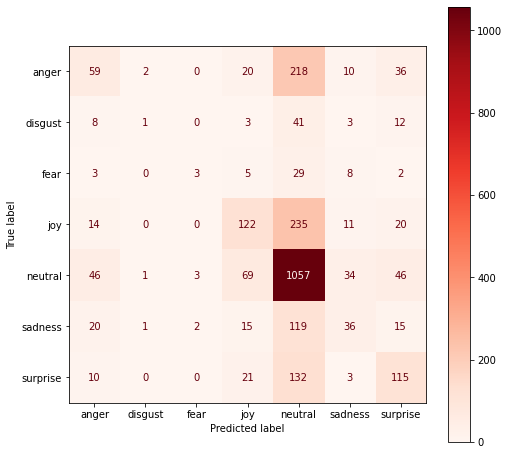

In [ ]:
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]

cnn_cm = confusion_matrix(y_true, y_pred, labels=le.classes_)
cm_display = ConfusionMatrixDisplay(cnn_cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8,8)) # adjust the size
cm_display.plot(ax=ax,cmap='Reds',values_format='')
plt.savefig('/content/drive/MyDrive/MINI/Saved Files/final_CNN_confusion_matrix.jpg')


def count_(df,x):
  ans = df.Emotion.value_counts()[x]
  return ans

# Labels = ['neutral', 'surprise', 'fear', 'sadness', 'joy', 'disgust','anger']
print("Total Different Emotion count in our testing dataset:")
for x in Labels:
  cnt = count_(data_test,x)
  print(str(x) + " : " + str(cnt))

In [ ]:
def get_prec_recall_per_emotion(cm):
    per_emotion_precision = []
    for i in range(len(cm)):
        count_per_emotion,accurate = 0,0
        for j in range(len(cm)):
            if i == j:
                accurate = cm[j][i]
            count_per_emotion += cm[j][i]
        per_emotion_precision.append(round((accurate/count_per_emotion)*100,3))
        
    per_emotion_recall = []
    for i in range(len(cm)):
        count_per_emotion,accurate = 0,0
        for j in range(len(cm)):
            if i == j:
                accurate = cm[i][j]
            count_per_emotion += cm[i][j]
        per_emotion_recall.append(round((accurate/count_per_emotion)*100,3))
        
    return per_emotion_precision, per_emotion_recall

In [ ]:
cnn_per_prec,cnn_per_recall = get_prec_recall_per_emotion(cnn_cm)
per_precision_list = pd.DataFrame({'CNN': cnn_per_prec})
per_precision_list

,CNN
0,36.875
1,20.000
2,37.500
3,47.843
4,57.728
5,34.286
6,46.748


In [ ]:
per_recall_list = pd.DataFrame({'CNN': cnn_per_recall})
per_recall_list

,CNN
0,17.101
1,1.471
2,6.000
3,30.348
4,84.156
5,17.308
6,40.925
